# Import Library

In [1]:
!pip install yfinance==0.2.54


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf


2025-03-14 12:54:37.388453: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 12:54:37.392823: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 12:54:37.481721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-14 12:54:37.481823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-14 12:54:37.482701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Import Data BBRI

In [3]:
start_date = "2020-03-13"
end_date = "2025-03-13"

data = yf.Ticker("BBRI.JK")
data = data.history(start=start_date, end=end_date)
data_forecast = data.copy()
data_forecast.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-06 00:00:00+07:00,3870.0,3990.0,3870.0,3950.0,434485100,0.0,0.0
2025-03-07 00:00:00+07:00,3930.0,3930.0,3810.0,3810.0,243793600,0.0,0.0
2025-03-10 00:00:00+07:00,3790.0,3810.0,3730.0,3760.0,232192200,0.0,0.0
2025-03-11 00:00:00+07:00,3700.0,3790.0,3660.0,3790.0,273961800,0.0,0.0
2025-03-12 00:00:00+07:00,3810.0,3920.0,3810.0,3890.0,271631200,0.0,0.0


In [4]:
data.to_csv("BBRI_stock_data.csv")

In [5]:
data_forecast.dropna(inplace=True)
data_forecast.drop(columns=["Dividends", "Stock Splits"], inplace=True)

In [6]:
data_forecast.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [7]:
data_forecast.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2025-03-06 00:00:00+07:00,3870.0,3990.0,3870.0,3950.0,434485100
2025-03-07 00:00:00+07:00,3930.0,3930.0,3810.0,3810.0,243793600
2025-03-10 00:00:00+07:00,3790.0,3810.0,3730.0,3760.0,232192200
2025-03-11 00:00:00+07:00,3700.0,3790.0,3660.0,3790.0,273961800
2025-03-12 00:00:00+07:00,3810.0,3920.0,3810.0,3890.0,271631200


## BBRI Stock Trend

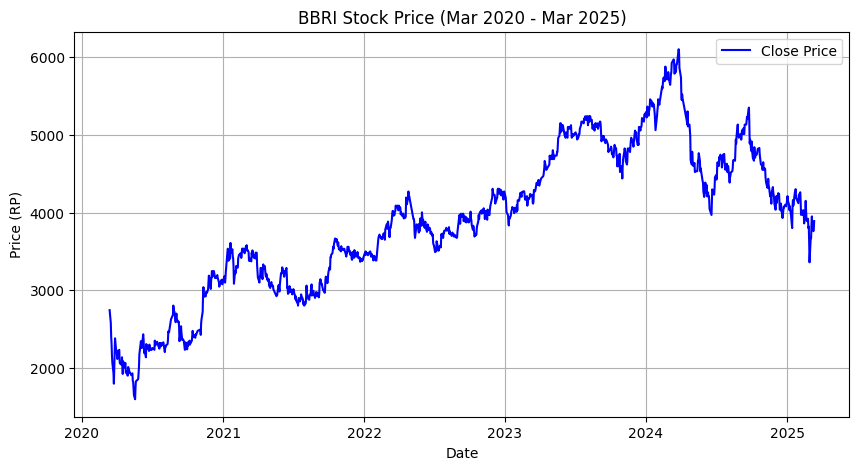

In [8]:
# Plot the closing price
plt.figure(figsize=(10, 5))
plt.plot(data_forecast.index, data_forecast['Close'], label="Close Price", color='blue', linestyle='-')

# Customize the chart
plt.title(f"BBRI Stock Price (Mar 2020 - Mar 2025)")
plt.xlabel("Date")
plt.ylabel("Price (RP)")
plt.legend()
plt.grid(True)

# Show the chart
plt.show()

# 

# Preprocessing

In [9]:
data_forecast['Close'].values.reshape(-1,1)

array([[2745.5859375 ],
       [2583.21240234],
       [2406.07788086],
       ...,
       [3760.        ],
       [3790.        ],
       [3890.        ]])

In [10]:
data_close = data_forecast['Close'].values.reshape(-1,1)

In [11]:

def create_sequences(data, sequence_length):
    label = []
    sequence = []
    for i in range(len(data)-sequence_length): 
        sequence.append(data[i:i+sequence_length])
        label.append(data[i+sequence_length])
    return np.array(sequence), np.array(label)

In [12]:
sequence_length = 30
train_size = 0.8 * len(data_forecast)

train = data_close[:int(train_size)]
test = data_close[int(train_size):]

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)
print("train_scaled shape:", train_scaled.shape)
print("test_scaled shape:", test_scaled.shape)

train_scaled shape: (965, 1)
test_scaled shape: (242, 1)


In [14]:
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)
print("x test shape:", X_test.shape)
print("y test shape:", y_test.shape)

x test shape: (212, 30, 1)
y test shape: (212, 1)


# Training Data

LSTM

In [15]:
model = tf.keras.models.Sequential([ 
    tf.keras.layers.LSTM(16, return_sequences=False, input_shape=[X_train.shape[1], 1]),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
]) 

In [16]:
model.compile(loss="mse",optimizer=tf.keras.optimizers.Adam())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1333 (5.21 KB)
Trainable params: 1333 (5.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
30/30 [==============================] - 6s 80ms/step - loss: 0.4141 - val_loss: 0.0993
Epoch 2/100
30/30 [==============================] - 1s 33ms/step - loss: 0.0881 - val_loss: 0.0431
Epoch 3/100
30/30 [==============================] - 1s 32ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 4/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0058 - val_loss: 0.0101
Epoch 5/100
30/30 [==============================] - 1s 32ms/step - loss: 0.0026 - val_loss: 0.0087
Epoch 6/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0016 - val_loss: 0.0079
Epoch 7/100
30/30 [==============================] - 1s 35ms/step - loss: 0.0014 - val_loss: 0.0078
Epoch 8/100
30/30 [==============================] - 1s 32ms/step - loss: 0.0014 - val_loss: 0.0081
Epoch 9/100
30/30 [==============================] - 1s 31ms/step - loss: 0.0014 - val_loss: 0.0076
Epoch 10/100
30/30 [==============================] - 1s 35ms/step - loss: 0.0014 - val_loss: 0.0071

# Evaluation Train & Test

In [18]:
import pandas as pd

training_history = model.history.history
training_df = pd.DataFrame(training_history)

print(training_df.tail())

        loss  val_loss
95  0.000455  0.002045
96  0.000465  0.002058
97  0.000463  0.002009
98  0.000468  0.002033
99  0.000448  0.002012


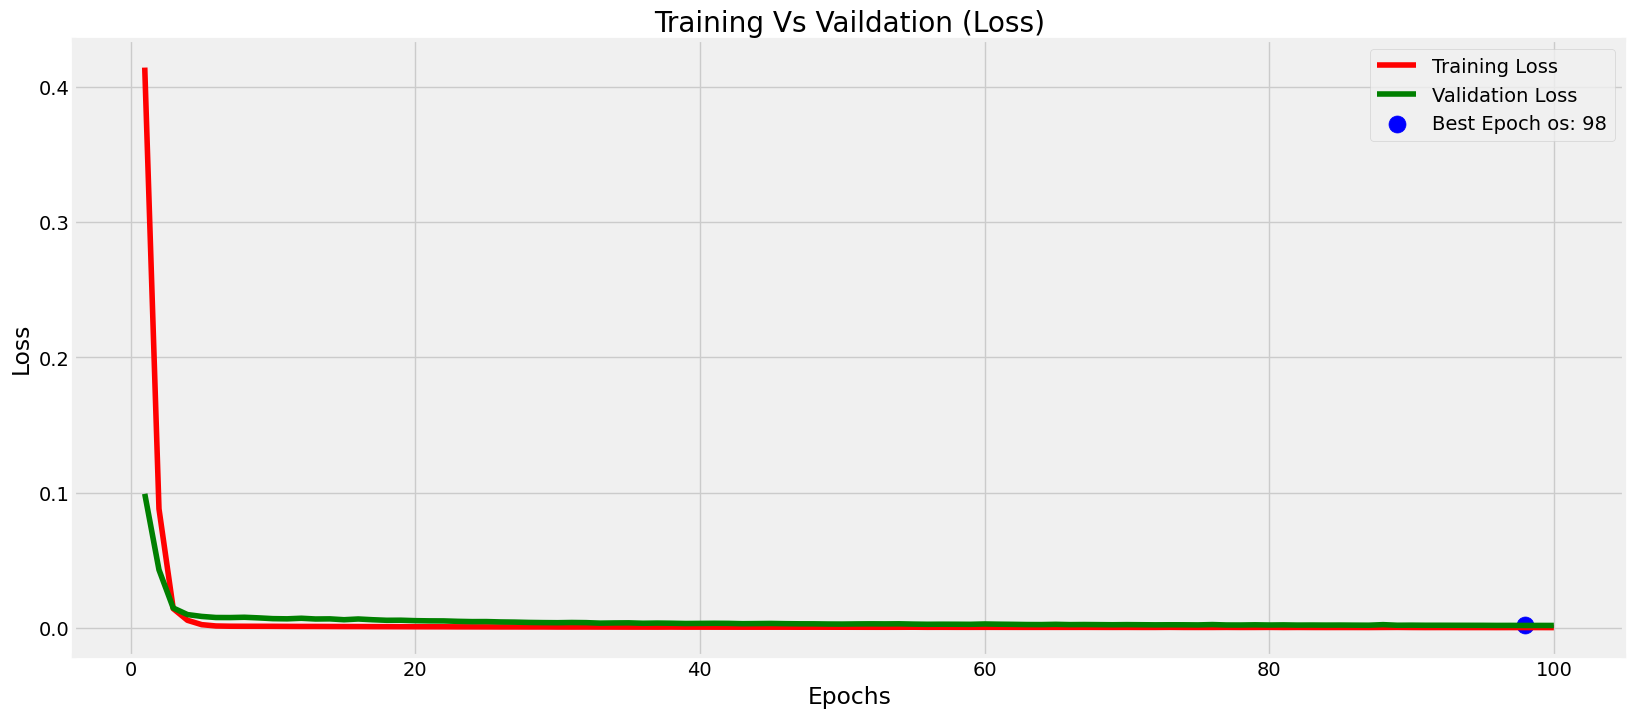

In [19]:
train_loss = model.history.history['loss']

val_loss = model.history.history['val_loss']

index_loss = np.argmin(val_loss)

val_lowest= val_loss[index_loss]

epochs= [i+1 for i in range(len(train_loss))]
loss_label = f"Best Epoch os: {str(index_loss +1)}"

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.plot(epochs , train_loss , 'r' , label= "Training Loss")
plt.plot(epochs , val_loss , 'g' , label= "Validation Loss")
plt.scatter(index_loss +1 , val_lowest , s= 150 , c = 'blue' , label= loss_label)
plt.title("Training Vs Vaildation (Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout
plt.show();

In [20]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
print("train_preds shape:", train_preds.shape)
print("test_preds shape:", test_preds.shape)

7/7 [==============================] - 0s 4ms/step
train_preds shape: (935, 1)
test_preds shape: (212, 1)


In [21]:
print("train_preds shape:", train_preds.shape)

train_preds shape: (935, 1)


In [22]:
train_preds = scaler.inverse_transform(train_preds)
print("train_preds shape:", train_preds.shape)

test_preds = scaler.inverse_transform(test_preds)
print("test_preds shape:", test_preds.shape)

y_train_preds = scaler.inverse_transform(y_train)
print("\ny train_preds shape:", train_preds.shape)

y_test_preds = scaler.inverse_transform(y_test)
print("y test preds shape:", test_preds.shape)

train_preds shape: (935, 1)
test_preds shape: (212, 1)

y train_preds shape: (935, 1)
y test preds shape: (212, 1)


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_preds, y_test_preds)
mae = mean_absolute_error(test_preds, y_test_preds)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 15081.069438773502
Mean Absolute Error (MAE): 98.58796202461674


# Prediction Vs Actual Price

In [24]:


last_30_days = data_close[-sequence_length:]
last_30_days_scaled = scaler.transform(last_30_days)

X_predict = []
X_predict.append(last_30_days_scaled)

X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

forecast = model.predict(X_predict)
forecast = scaler.inverse_transform(forecast)

print("forecast BBRI:", forecast[0][0])

1/1 [==============================] - 0s 18ms/step
forecast BBRI: 3804.3623


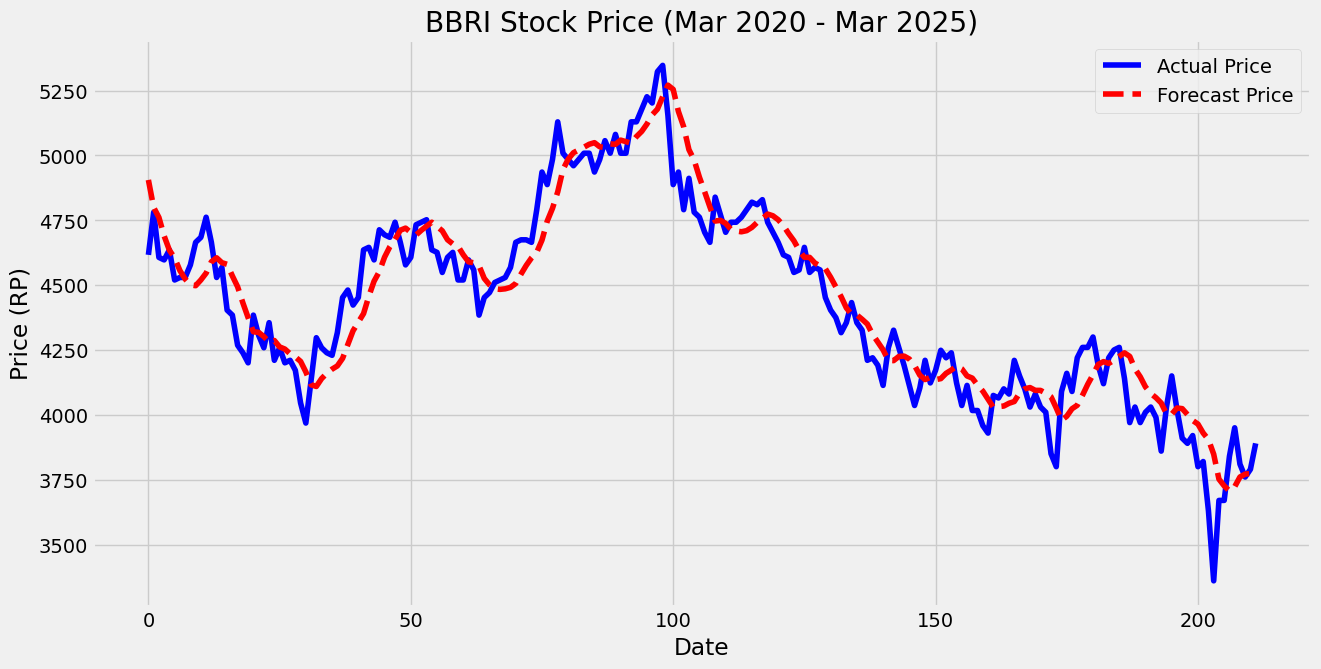

In [25]:


plt.figure(figsize=(14, 7))

plt.plot(y_test_preds, label="Actual Price", color='blue', linestyle='-')
plt.plot(test_preds, label="Forecast Price", color='red', linestyle='--')
plt.title(f"BBRI Stock Price (Mar 2020 - Mar 2025)")
plt.xlabel("Date")
plt.ylabel("Price (RP)")
plt.legend()
plt.grid(True)

plt.show()

# Prediction future price 1 Month

In [26]:
future_day = 100

last_30_day = data['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_day)
future_prediction = []

for i in range(future_day):
    X_predict = []
    X_predict.append(last_30_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))
    forecast = model.predict(X_predict)
    forecast_unscaled = scaler.inverse_transform(forecast)
    future_prediction.append(forecast_unscaled[0][0])

    new_scaled_data = np.append(last_30_days_scaled[1:], forecast, axis=0)
    last_30_days_scaled = new_scaled_data.reshape(-1, 1)

print("forecast BBRI:", forecast_unscaled[0][0])
future_dates = pd.date_range(start=data.index[-1], periods=future_day + 1, freq="D")[1:]

1/1 [==============================] - 0s 16ms/step
forecast BBRI: 4146.264


In [27]:
future_prediction

[3804.3623,
 3810.0447,
 3815.8352,
 3821.3594,
 3826.6826,
 3831.7725,
 3836.6365,
 3841.4954,
 3846.2646,
 3851.0352,
 3855.7944,
 3860.4958,
 3865.0679,
 3869.7542,
 3874.51,
 3879.1323,
 3883.6367,
 3888.0955,
 3892.546,
 3896.8618,
 3901.156,
 3905.2502,
 3909.0715,
 3913.1116,
 3917.1023,
 3921.1895,
 3925.3228,
 3929.289,
 3933.1685,
 3937.032,
 3940.9414,
 3944.7341,
 3948.4922,
 3952.2153,
 3955.9045,
 3959.5596,
 3963.181,
 3966.7693,
 3970.3252,
 3973.849,
 3977.342,
 3980.8037,
 3984.236,
 3987.6392,
 3991.0137,
 3994.3604,
 3997.6794,
 4000.9722,
 4004.2388,
 4007.4797,
 4010.6953,
 4013.8872,
 4017.0544,
 4020.1982,
 4023.3186,
 4026.417,
 4029.493,
 4032.5474,
 4035.581,
 4038.5942,
 4041.587,
 4044.5603,
 4047.5142,
 4050.449,
 4053.3655,
 4056.2637,
 4059.144,
 4062.0073,
 4064.8538,
 4067.683,
 4070.4963,
 4073.2935,
 4076.0747,
 4078.841,
 4081.5918,
 4084.3284,
 4087.0503,
 4089.7583,
 4092.4521,
 4095.1323,
 4097.7993,
 4100.4536,
 4103.095,
 4105.723,
 4108.34,
 4

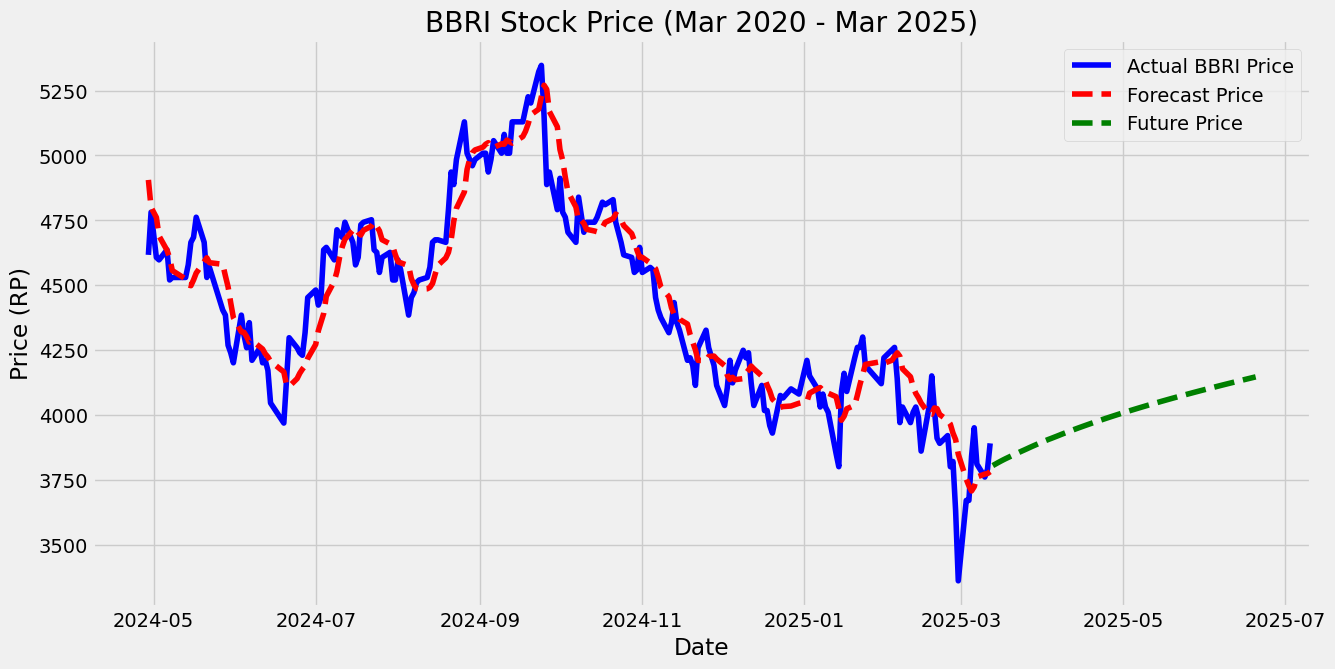

In [28]:
plt.figure(figsize=(14, 7))

plt.plot(data.index[-len(y_test_preds):], y_test_preds, label="Actual BBRI Price", color='blue', linestyle='-')
plt.plot(data.index[-len(y_test_preds):],test_preds, label="Forecast Price", color='red', linestyle='--')
plt.plot(future_dates,future_prediction, label="Future Price", color='green', linestyle='--')
plt.title(f"BBRI Stock Price (Mar 2020 - Mar 2025)")
plt.xlabel("Date")
plt.ylabel("Price (RP)")
plt.legend()
plt.grid(True)

plt.show()